### Task 1: Plot the evolution of the stock and the log-returns and investigate their mean, std, minimum, maximum and their quantiles

In [482]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [483]:
data = pd.read_csv("Telekom.csv")
data.head()

,Date,Close
0,2014-06-17,12.585
1,2014-06-18,12.660
2,2014-06-19,12.800
3,2014-06-20,12.735
4,2014-06-23,12.675


In [484]:
data.dtypes

Date      object
Close    float64
dtype: object

In [485]:
data["Date"] = pd.to_datetime(data["Date"])
data.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [486]:
if len(data.columns) == 2:
    data.set_index('Date',inplace=True)
    print('Date is the new index of data')


Date is the new index of data


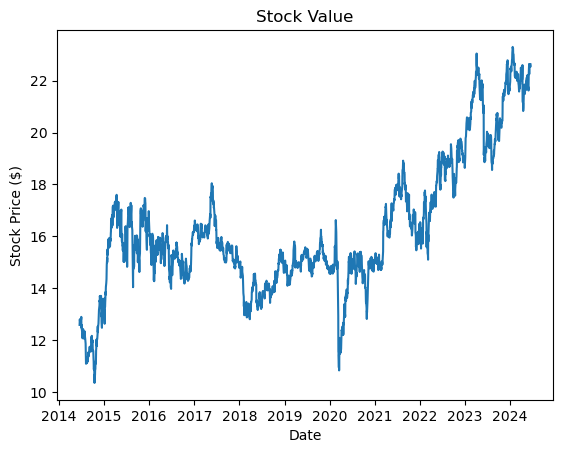

In [487]:
plt.title('Stock Value')
plt.plot(data["Close"])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.grid(False)

In [488]:
stats = [

    ('Mean', data['Close'].mean()),
    ('Std Dev', data['Close'].std()),
    (f"Min (on {data['Close'].idxmin().date()})", data['Close'].min()),
    (f"Max (on {data['Close'].idxmax().date()})", data['Close'].max()),
    ('25% Quantile (Q1)', data['Close'].quantile(0.25)),
    ('Median (Q2)', data['Close'].quantile(0.50)),
    ('75% Quantile (Q3)', data['Close'].quantile(0.75)),
]

# Turn the list into a DataFrame and keep the name 'stats'
stats = pd.DataFrame(stats, columns=['Statistics of Returns', 'Value'])
stats['Value'] = round(stats['Value'],2)
stats


,Statistics of Returns,Value
0,Mean,16.28
1,Std Dev,2.59
2,Min (on 2014-10-16),10.35
3,Max (on 2024-01-22),23.30
4,25% Quantile (Q1),14.77
5,Median (Q2),15.64
6,75% Quantile (Q3),17.48


The log returns are defined as
$$
r_t = ln\left(\frac{P_{t}}{P_{t-1}}\right) = ln(P_{t})-ln(P_{t-1})
$$

In [489]:
logPrices = np.log(np.array(data["Close"]))
data["LogReturn"] = np.log(data['Close']).diff()
data.tail()

,Close,LogReturn
Date,,
2024-06-10,22.610001,0.000885
2024-06-11,22.610001,0.000000
2024-06-12,22.540001,-0.003101
2024-06-13,22.530001,-0.000444
2024-06-14,22.629999,0.004429


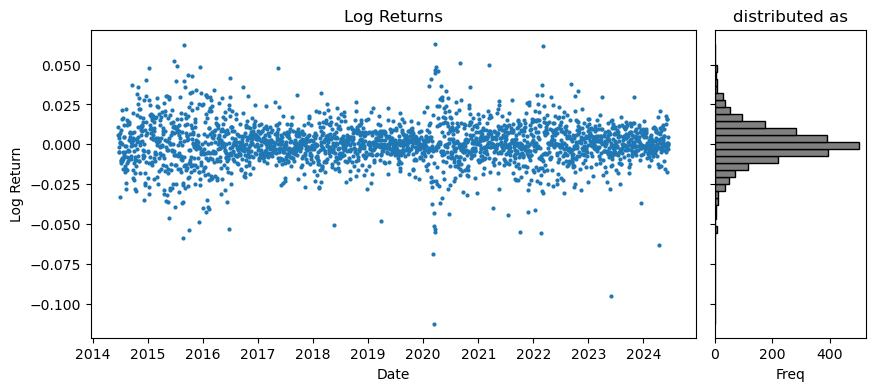

In [490]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.05})

ax1.plot(data.index, data['LogReturn'], marker='.', ls='',markersize='4')
ax1.set_title('Log Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Return')

ax2.set_title('distributed as')
ax2.hist(data['LogReturn'].dropna(), bins=40, orientation='horizontal', color='gray', edgecolor='black',density=False)
ax2.set_xlabel('Freq')
ax2.tick_params(labelleft=False)  # Hide y-axis labels on histogram


plt.show()

In [491]:
logReturns = data['LogReturn'].dropna()
logstats = {
    'Mean': logReturns.mean(),
    'Std': logReturns.std(),
    'Minimum': logReturns.min(),
    'Maximum': logReturns.max(),
    '25% Quantile (Q1)': logReturns.quantile(0.25),
    'Median (Q2)': logReturns.quantile(0.50),
    '75% Quantile (Q3)': logReturns.quantile(0.75),
}

# Convert to DataFrame
pd.DataFrame.from_dict(logstats, orient='index', columns=['Value'])

,Value
Mean,0.000231
Std,0.013379
Minimum,-0.112673
Maximum,0.063141
25% Quantile (Q1),-0.005909
Median (Q2),0.000000
75% Quantile (Q3),0.007092


### 📈 Task 2 – Fit the Black-Scholes Model to `Telecom.csv`

In this task, we estimate the parameters of the **Black-Scholes model** using historical price data from `Telecom.csv`.

---

🧾 **Black-Scholes Model**

The Black-Scholes model assumes the asset price follows the stochastic differential equation (SDE):

$$
dP_t = P_t \left( b\,dt + \sigma\,dW_t \right)
$$

Applying **Itô's Lemma** to the logarithm of the price process, we obtain:

$$
d(\log P_t) = \left(b - \frac{1}{2} \sigma^2 \right) dt + \sigma\, dW_t
$$

---

🔍 **Estimation via Log Returns**

Using a time series of prices $P_t$, we approximate the differential of the log price by the **discrete log return**:

$$
r_t \approx \log(P_{t+1}) - \log(P_t)
$$

From this, we can estimate the model parameters:

- **Volatility (σ)**:
  $$
  \sigma \approx \text{std}(r_t)
  $$

- **Drift (b)**:
  $$
  b \approx \text{mean}(r_t) + \frac{1}{2} \sigma^2
  $$

---

⏱️ Time Units and Annualization

These estimates are computed per trading day. To convert to **annualized values**, use:

- $\sigma_{\text{annual}} = \sigma_{\text{daily}} \cdot \sqrt{252}$
- $b_{\text{annual}} = b_{\text{daily}} \cdot 252$

> 📝 Note: 252 is the typical number of trading days in a year.

---




In [492]:
P0 = np.array(data["Close"])[0]
r = 0.02  # by assumption
sigma = logstats["Std"] * np.sqrt(252)
b = logstats["Mean"] * 252 + 0.5 * sigma * sigma

print('The parameters of the Black-Scholes Model are:')
print(f'Initial Price P0 ($):       {P0:.2f}')
print(f'Interest Rate (annual):    {r:.2%}')
print(f'Volatility σ (annual):      {sigma:.4f}')
print(f'Drift b (annual):               {b:.4f}')

The parameters of the Black-Scholes Model are:
Initial Price P0 ($):       12.59
Interest Rate (annual):    2.00%
Volatility σ (annual):      0.2124
Drift b (annual):               0.0808



### 📘 Task 3 – Bonus Certificates

💡 **What Are Bonus Certificates?**

Bonus Certificates are structured financial products that offer investors participation in the performance of an underlying asset (e.g., a stock or index), while also providing partial downside protection and the possibility of a bonus payment at maturity.

They are popular retail derivatives in Europe and are issued by banks. These products usually combine:

- A **long position** in the underlying (or a portion of it)
- A **short put option** (sold by the investor)
- A **bonus feature** that rewards the investor if a barrier is not breached

---

💰 **Payoff at maturity**

Let:

- $ S_T $: price of the underlying at maturity
- $ B $: barrier level
- $ K $: bonus level (guaranteed payoff if barrier is not touched)

Then the payoff $ \Pi_T $ is typically:

$$
\Pi_T =
\begin{cases}
K & \text{if } S_t \geq B \text{ for all } t \in [0, T] \\
S_T & \text{if } S_t < B \text{ at any time}
\end{cases}
$$

This means:

- If the **barrier is never breached**, the investor gets at least the bonus level $ K $, even if the underlying finishes below $ K $.
- If the **barrier is breached**, the investor simply receives the final value $ S_T $, just like holding the underlying asset.

-----

🎯 **Why Would an Investor Buy One?**

Investors are drawn to Bonus Certificates for several reasons:

- **Partial downside protection**: as long as the barrier isn't breached, the bonus guarantees a minimum return.
- **Enhanced returns in sideways markets**: if the underlying stagnates but doesn't fall below the barrier, the investor still gets the bonus.
- **Lower cost than direct equity**: they are often cheaper than buying stocks outright due to the embedded options.

---

⚠️ **Risks to Consider**

While attractive, Bonus Certificates carry important risks:

1. **Barrier breach risk**: if the barrier is touched, protection is lost and the investor participates fully in losses.
2. **Credit risk**: the product is issued by a bank — if the issuer defaults, the protection and return may be worthless.
3. **Liquidity risk**: they may not be easily tradable in the secondary market.



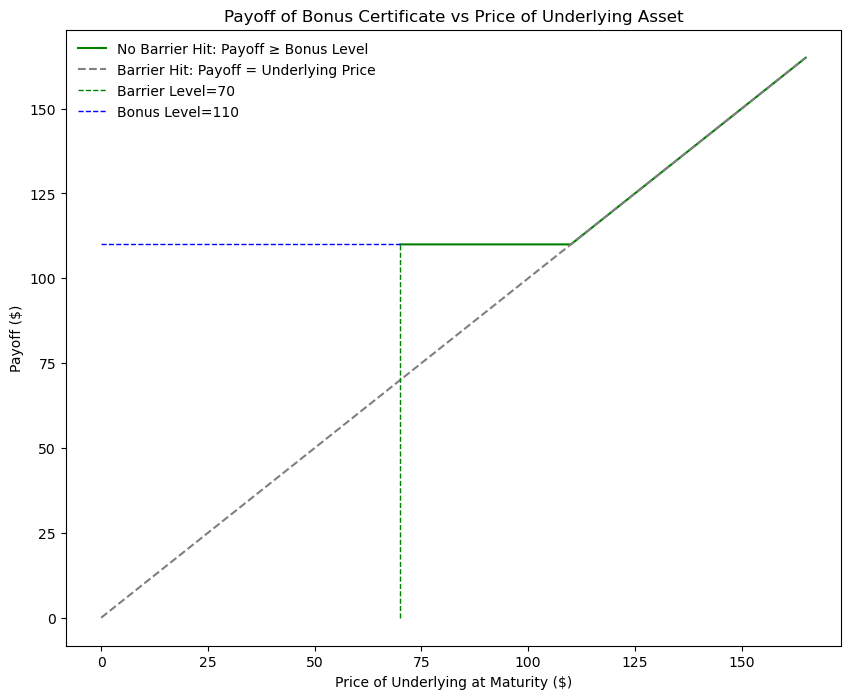

In [493]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

P0 = 100
bonuslevel = 110
barrier = 70
assert barrier <= P0 <= bonuslevel

PT = np.linspace(0, 1.5 * bonuslevel, int(10 * bonuslevel))  # fine grid
payoff = np.maximum(PT[PT > barrier], bonuslevel)
underlying = PT
plt.figure(figsize=(10,8))
plt.title("Payoff of Bonus Certificate vs Price of Underlying Asset")
plt.plot(PT[PT > barrier], payoff, color='green', label='No Barrier Hit: Payoff ≥ Bonus Level')
plt.plot(PT, underlying, ls='--', color='grey', label='Barrier Hit: Payoff = Underlying Price')
plt.plot([barrier, barrier], [0, bonuslevel], lw=1, ls='--', color='green', label=f'Barrier Level={barrier}')
plt.plot([0, barrier], [bonuslevel, bonuslevel], lw=1, ls='--', color='blue', label=f'Bonus Level={bonuslevel}')
plt.xlabel('Price of Underlying at Maturity ($)')
plt.ylabel('Payoff ($)')
plt.legend(loc='best',frameon=False)
plt.show()


### Task 4 - Find a portfolio of products that replicate the certificate
The payoff of the bonus certificate can be expressed as
$$
\text{Bonus}(T) = 
\underset{\text{Underlying}}{\underline{P_T}} 
+ 
\underset{\text{Out-and-out Put (Strike = Bonus Level)}}{\underline{(B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H,\ \forall t \in [0,T]\}}}}
$$
where $H$ is the value of the Barrier level threshold, and $B$ is the bonus value.


The payoff of the capped bonus certificate can be expressed as 
$$
\text{Bonus}(T,C) = \text{Bonus}(T) - \underset{\text{Call (Strike = Cap Level)}}{\underline{(P_T-C)^+}}
$$


### Task 5 - Determine a fair price for each of the certificates.
and compute it for the market parameters with parameters $H=16$, $B=16$, $T=1$ year.

The fair price is the risk neutral expected discounted payoff which can be calculated as a function of known derivatives thanks to Task 4

$$
\begin{aligned}
\text{Bonus}(0) &= \mathbb{E}_{\tilde{\mathbb{Q}}} [e^{-rT}P_T] + \mathbb{E}_{\tilde{\mathbb{Q}}} [e^{-rT}(B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H,\ \forall t \in [0,T]\}}]
\\
&= P_0 + \text{?}
\end{aligned}
$$

where $Q^{(1)}$ and $Q^{(1)}$ are given by
$$
\begin{aligned}
& Q^{(1)}=\mathcal{N}\left(\frac{\log \left(\frac{P_0}{H}\right)+\left(r+\frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right)-\exp \left(-\frac{2\left(r+\frac{\sigma^2}{2}\right) \log \left(\frac{P_0}{H}\right)}{\sigma^2}\right) \mathcal{N}\left(\frac{-\log \left(\frac{P_0}{H}\right)+\left(r+\frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) \\
& Q^{(2)}=\mathcal{N}\left(\frac{\log \left(\frac{P_0}{H}\right)+\left(r-\frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right)-\exp \left(-\frac{2\left(r-\frac{\sigma^2}{2}\right) \log \left(\frac{P_0}{H}\right)}{\sigma^2}\right) \mathcal{N}\left(\frac{-\log \left(\frac{P_0}{H}\right)+\left(r-\frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right)
\end{aligned}
$$

where $\mathcal{N}$ denotes the cumulative distribution function of the standard normal distribution.

We can calculate the fair price of the capped bonus certificate using the Black-Scholes price for a call option
$$
\text{Bonus}(0,C) = \text{Bonus}(0) - \text{Call}(0,C)
$$
we can clearly see that the fair price of the capped bonus is lower than the standard bonus certificate, because it has stricly lower payoff.



In [494]:
data.head()

,Close,LogReturn
Date,,
2014-06-17,12.585,NaN
2014-06-18,12.660,0.005942
2014-06-19,12.800,0.010998
2014-06-20,12.735,-0.005091
2014-06-23,12.675,-0.004723


In [495]:
P0 = data["Close"][pd.to_datetime("2024-06-14")]
H = 16
B = 24
C = 50
T = 1
print(f'The parameters for the pricing are')
print(f'Maturity: {T} year(s)')
print(f'Initial Price: {P0:.3f}')
print(f'Interest rate: {r}')
print(f'Volatility: {sigma:.3f}')
print(f'Barrier H: {H}')
print(f'Bonus Level B: {B}')
print(f'Capped Payoff C: {C}')



The parameters for the pricing are
Maturity: 1 year(s)
Initial Price: 22.630
Interest rate: 0.02
Volatility: 0.212
Barrier H: 16
Bonus Level B: 24
Capped Payoff C: 50


In [496]:
from scipy.stats import norm
# incomplete Q1 and Q2 are not sufficient to calculate d&o put

def Q1(P0=P0, H=H, r=r, sigma=sigma, T=T):
    log_term = np.log(P0 / H)
    drift = r + 0.5 * sigma**2
    denom = sigma * np.sqrt(T)

    term1 = norm.cdf((log_term + drift * T) / denom)
    
    exponent = - (2 * drift * log_term) / sigma**2
    term2 = np.exp(exponent) * norm.cdf((-log_term + drift * T) / denom)

    return term1 - term2

def Q2(P0=P0, H=H, r=r, sigma=sigma, T=T):
    log_term = np.log(P0 / H)
    drift = r - 0.5 * sigma**2
    denom = sigma * np.sqrt(T)

    term1 = norm.cdf((log_term + drift * T) / denom)
    
    exponent = - (2 * drift * log_term) / sigma**2
    term2 = np.exp(exponent) * norm.cdf((-log_term + drift * T) / denom)

    return term1 - term2
    
print(Q1(P0,H,r,sigma,T))
print(Q2(P0,H,r,sigma,T))

print(
   P0 + P0*Q1() - np.exp(-r*T)*B*Q2()
)
print('This price is not correct!')

0.9270177014491856
0.8953527727340579
22.5454425671667
This price is not correct!


  **Pol takes care of Task 5 and deriving the correct formula using Q1 and Q2**

In [497]:
from barrier_option import bsm_barrier_option
downoutPut = bsm_barrier_option(k=B,s=P0,h=H,t=T,r=r,sig=sigma,rebate=0,payoff='out',oi=-1,n=1)
print(f'Price of the down & out put option: {downoutPut:.3f}')
print(f'Initial price of underlying: {P0:.3f}')
print(f'Fair price of the bonus certificate: {(P0 + downoutPut):.3f}')

Price of the down & out put option: 1.724
Initial price of underlying: 22.630
Fair price of the bonus certificate: 24.354


**Task 6. Monte Carlo Pricing**

We can approximate the risk neutral expectation using the law of large numbers. However, we need to simulate the price process $P_t$ with respect to the risk neutral probability measure. According to the Black Scholes framework

$$
P_t = P_0 e^{(r-\frac{1}{2}\sigma^2)t+ \sigma \tilde{W_t}}
$$

where $\tilde{W_t}$ is a Brownian motion w.r.t. $\tilde{\mathbb{Q}}$. We must simulate the paths, and calculate 
$$
P_T
+ 
(B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H,\ \forall t \in [0,T]\}}
$$

30.718441381627965
28.522158135197788
35.3580826593304
27.045811122830408
25.95243390662887


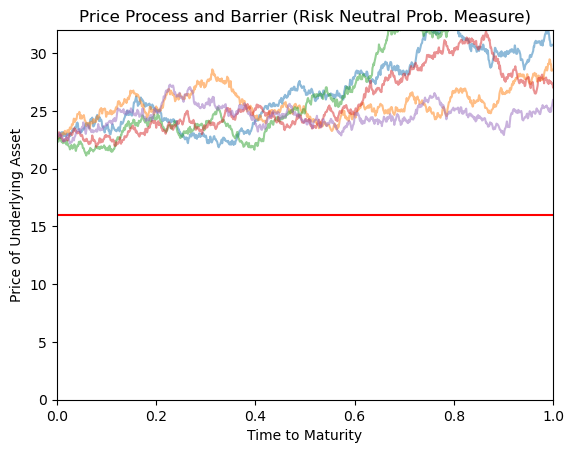

In [498]:
def BM(T,n):
    """
    Simulate a Brownian motion path.

    Parameters
    ----------
    T : float
        The time horizon.
    n : int
        The number of time steps.
    """
    dt = T / n
    t = np.linspace(0,T,n+1)
    W = np.zeros(n+1)
    W[1:] = np.cumsum(np.sqrt(dt) * np.random.normal(size=n))
    return t, W

def PriceProcess(T,P0,sigma,r,n=10000):
    """    
    Simulate a Geometric Brownian motion path.

    Parameters
    ----------
    T : float
        The time horizon.
    n : int
        The number of time steps.
    """
    dt = T / n
    t = np.linspace(0,T,n+1)
    X = np.zeros(n+1)
    X[1:] = np.cumsum(
        (r-0.5*sigma*sigma) * dt 
        + sigma * np.sqrt(dt) * np.random.standard_normal(size=n)
    )
    P = P0 * np.exp(X)
    return t,P

for _ in range(5):
    t,P = PriceProcess(T=T,P0=P0,sigma=sigma,r=r,n=1000)
    plt.plot(t,P,alpha=0.5)
    print(P[-1])
plt.plot([0,1],[H,H],color='red')
plt.xlim((0,1))
plt.ylim(0,2 * H)
plt.title('Price Process and Barrier (Risk Neutral Prob. Measure)')
plt.xlabel('Time to Maturity')
plt.ylabel('Price of Underlying Asset')
plt.show()


In [499]:
def Payoff(Pt,H,B):
    PT = Pt[-1]
    if np.min(Pt)>H:
        return (PT + max(0,B-PT),False)
    else:
        return (PT,True)

for _ in range(10):
    _ ,Pt = PriceProcess(T,P0,sigma,r)
    payoff, hit = Payoff(Pt,H,B)
    if (hit): print(f'Payoff: {payoff:.3f} Barrier Hit')
    else: print(f'Payoff: {payoff:.3f}')
    

Payoff: 24.000
Payoff: 24.000
Payoff: 24.000
Payoff: 26.684
Payoff: 26.027
Payoff: 25.134
Payoff: 29.450
Payoff: 24.000
Payoff: 24.000
Payoff: 18.172 Barrier Hit


In [500]:
from tqdm import tqdm

MT_steps = int(100000)
def MTBonus(T,P0,r,sigma,B,H,steps=MT_steps):
    disc = np.exp(-r*T)
    disc_payoffs = []
    for _ in tqdm(range(steps)):
        _,Pt = PriceProcess(T,P0,sigma,r)
        payoff,hit = Payoff(Pt,H,B)
        disc_payoffs.append(disc * payoff)
    fairPrice = np.mean(disc_payoffs)
    return fairPrice

mt_price = MTBonus(T,P0,r,sigma,B,H,MT_steps)
print(f'Estimator of Risk Neutral Price of Basic Bonus: {mt_price:.3f}')



100%|██████████| 100000/100000 [00:16<00:00, 5968.22it/s]

Estimator of Risk Neutral Price of Basic Bonus: 24.268
